<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Project <br>
<font color=696880 size=4>
    Project Team 
    
    
____


### Full Name : Amirhossein Abedi - Ali Salesi
### Student Number : 99105594 - 99105334
___

# Introduction

In this project, we are going to have a brief and elementary hands-on real-world project, predicting breast cancer survival using machine learning models with clinical data and gene expression profiles.

# Data Documentation

For this purpose, we will use "Breast Cancer Gene Expression Profiles (METABRIC)" data. 
The first 31 columns of data contain clinical information including death status.
The next columns of the data contain gene's related information which includes both gene expressions and mutation information. (gene's mutation info columns have been marked with "_mut" at the end of the names of the columns) 
For more information please read the [data documentation](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric).

In [1]:
import torch.nn.functional as F
from torch import nn
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import xgboost as xgb
plt.rcParams["figure.figsize"] = (20, 15)


# Data Preparation (15 Points)

In this section you must first split data into three datasets:
<br>
1- clinical dataset
<br>
2- gene expressions dataset
<br>
3- gene mutation dataset. (We will not use this dataset in further steps of the project)

## Data Loading & Splitting

In [2]:
df = pd.read_csv('METABRIC_RNA_Mutation.csv', low_memory=False)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 693 entries, patient_id to siah1_mut
dtypes: float64(498), int64(5), object(190)
memory usage: 10.1+ MB


In [3]:
df.head()


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [4]:
for idx, col in enumerate(df.columns):
    df[col].fillna('Unk' if 'O' == df.dtypes[idx] else 0, inplace=True)


In [5]:
cols_expr = [i for i in df.columns[31:] if not i.endswith('_mut')]
cols_clin = df.columns[:31]
len(cols_expr), len(cols_clin)


(489, 31)

In [6]:
df_expr = df[cols_expr]
df_clin = df[cols_clin]

label = np.array(df['overall_survival'])


In [7]:
arr_expr = np.array(df_expr)


In [8]:
from sklearn.preprocessing import LabelEncoder


df_clin_wo_dataleak = df[[i for i in cols_clin if not i in [
    'patient_id', 'death_from_cancer', 'overall_survival_months', 'overall_survival']]]
arr_clin = np.zeros((len(df_clin_wo_dataleak), len(
    df_clin_wo_dataleak.columns)), dtype=np.float32)
le_s = {}
for idx, col in enumerate(df_clin_wo_dataleak):
    if not df_clin_wo_dataleak.dtypes[idx] == 'O':
        arr_clin[:, idx] = np.array(df_clin_wo_dataleak[col], dtype=np.float32)
        continue
    temp = LabelEncoder()
    temp.fit(df_clin_wo_dataleak[col])
    le_s[col] = temp
    arr_clin[:, idx] = np.array(temp.transform(
        df_clin_wo_dataleak[col]), dtype=np.float32)

## EDA

For each dataset, you must perform a sufficient EDA.

C:\Users\ali_s\AppData\Local\Temp\ipykernel_31132\549398776.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_clin_wo_dataleak.corr()


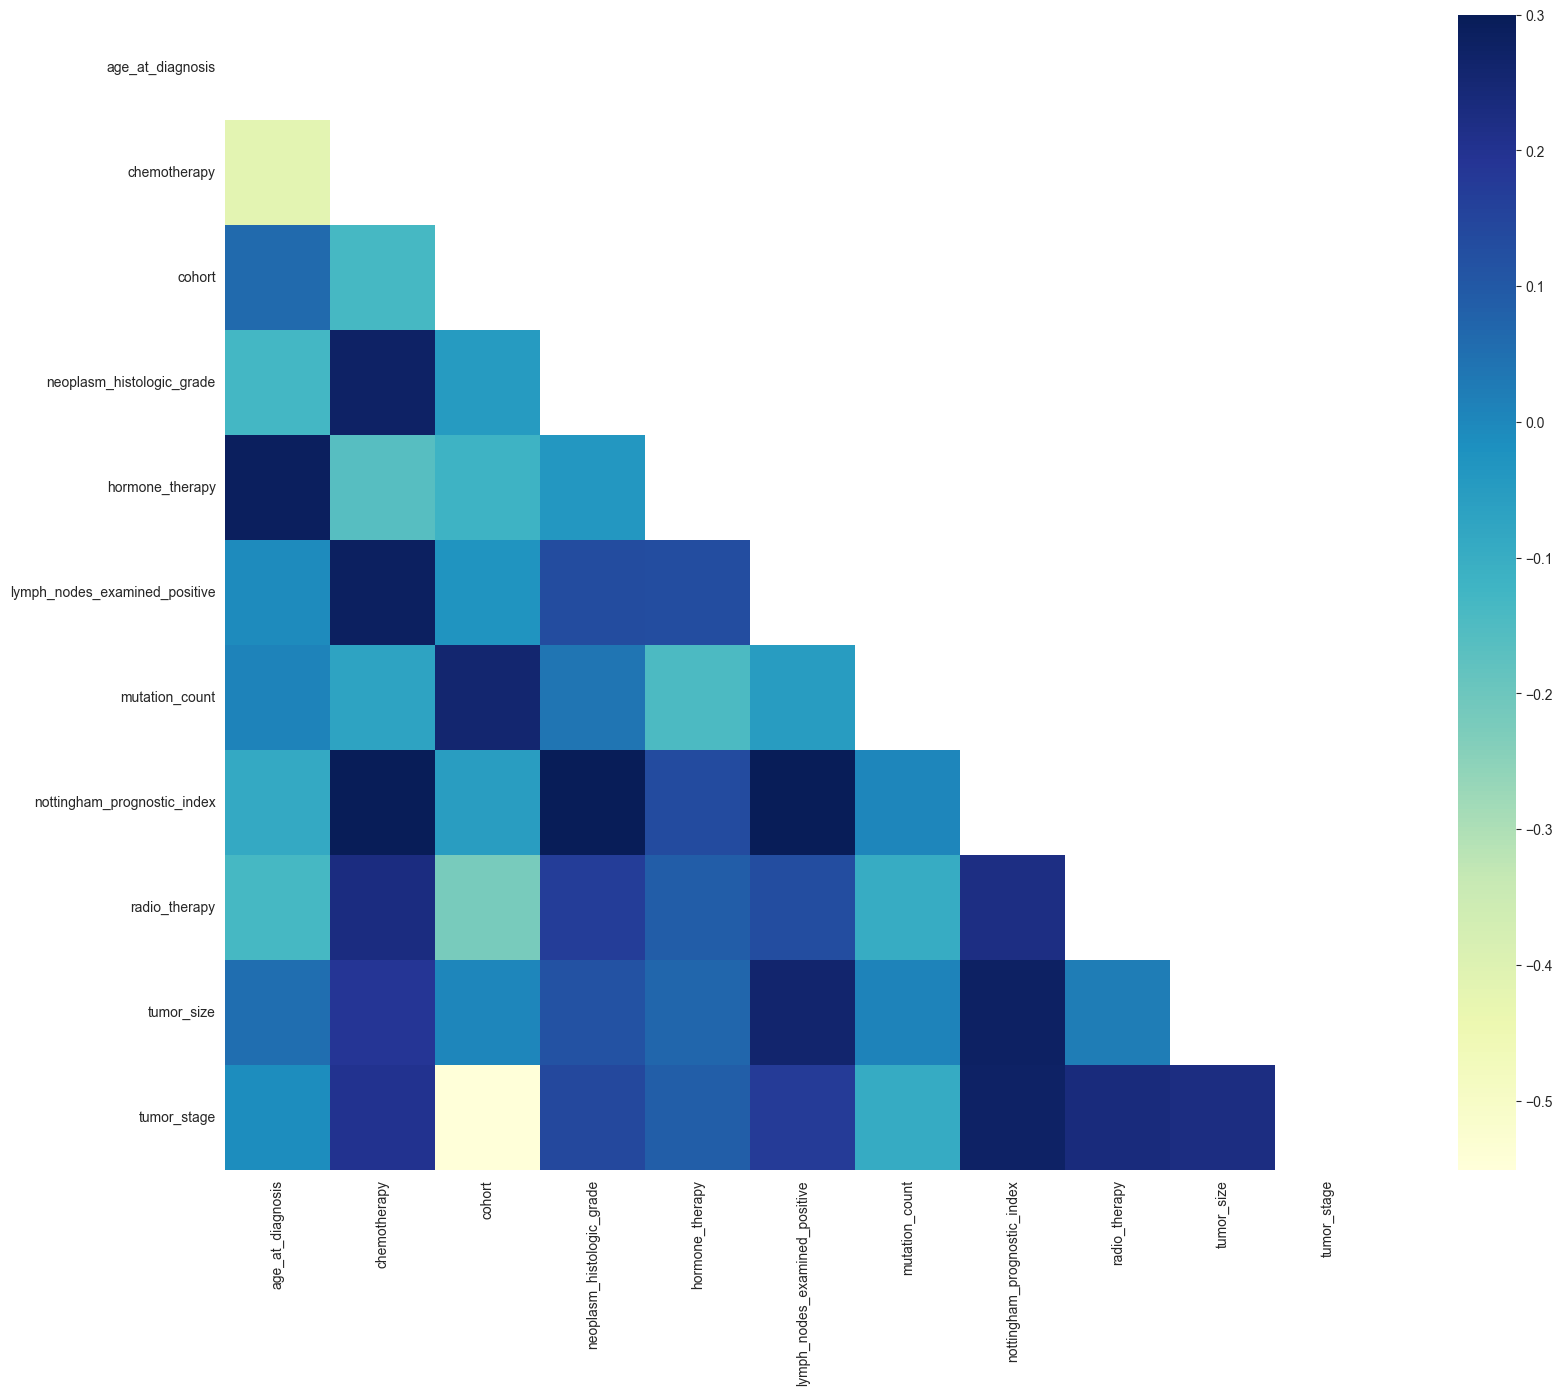

In [22]:
import seaborn as sns

corr = df_clin_wo_dataleak.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()

In [17]:
df_clin_wo_dataleak.describe()

,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,radio_therapy,tumor_size,tumor_stage
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,61.087054,0.207983,2.643908,2.324580,0.616597,2.002101,5.563025,4.033019,0.597164,25.963109,1.289916
std,12.978711,0.405971,1.228615,0.787251,0.486343,4.079993,4.102883,1.144492,0.490597,15.316629,0.941250
min,21.930000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,51.375000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.046000,0.000000,17.000000,0.000000
50%,61.770000,0.000000,3.000000,2.000000,1.000000,0.000000,5.000000,4.042000,1.000000,22.410000,1.000000
75%,70.592500,0.000000,3.000000,3.000000,1.000000,2.000000,7.000000,5.040250,1.000000,30.000000,2.000000
max,96.290000,1.000000,5.000000,3.000000,1.000000,45.000000,80.000000,6.360000,1.000000,182.000000,4.000000


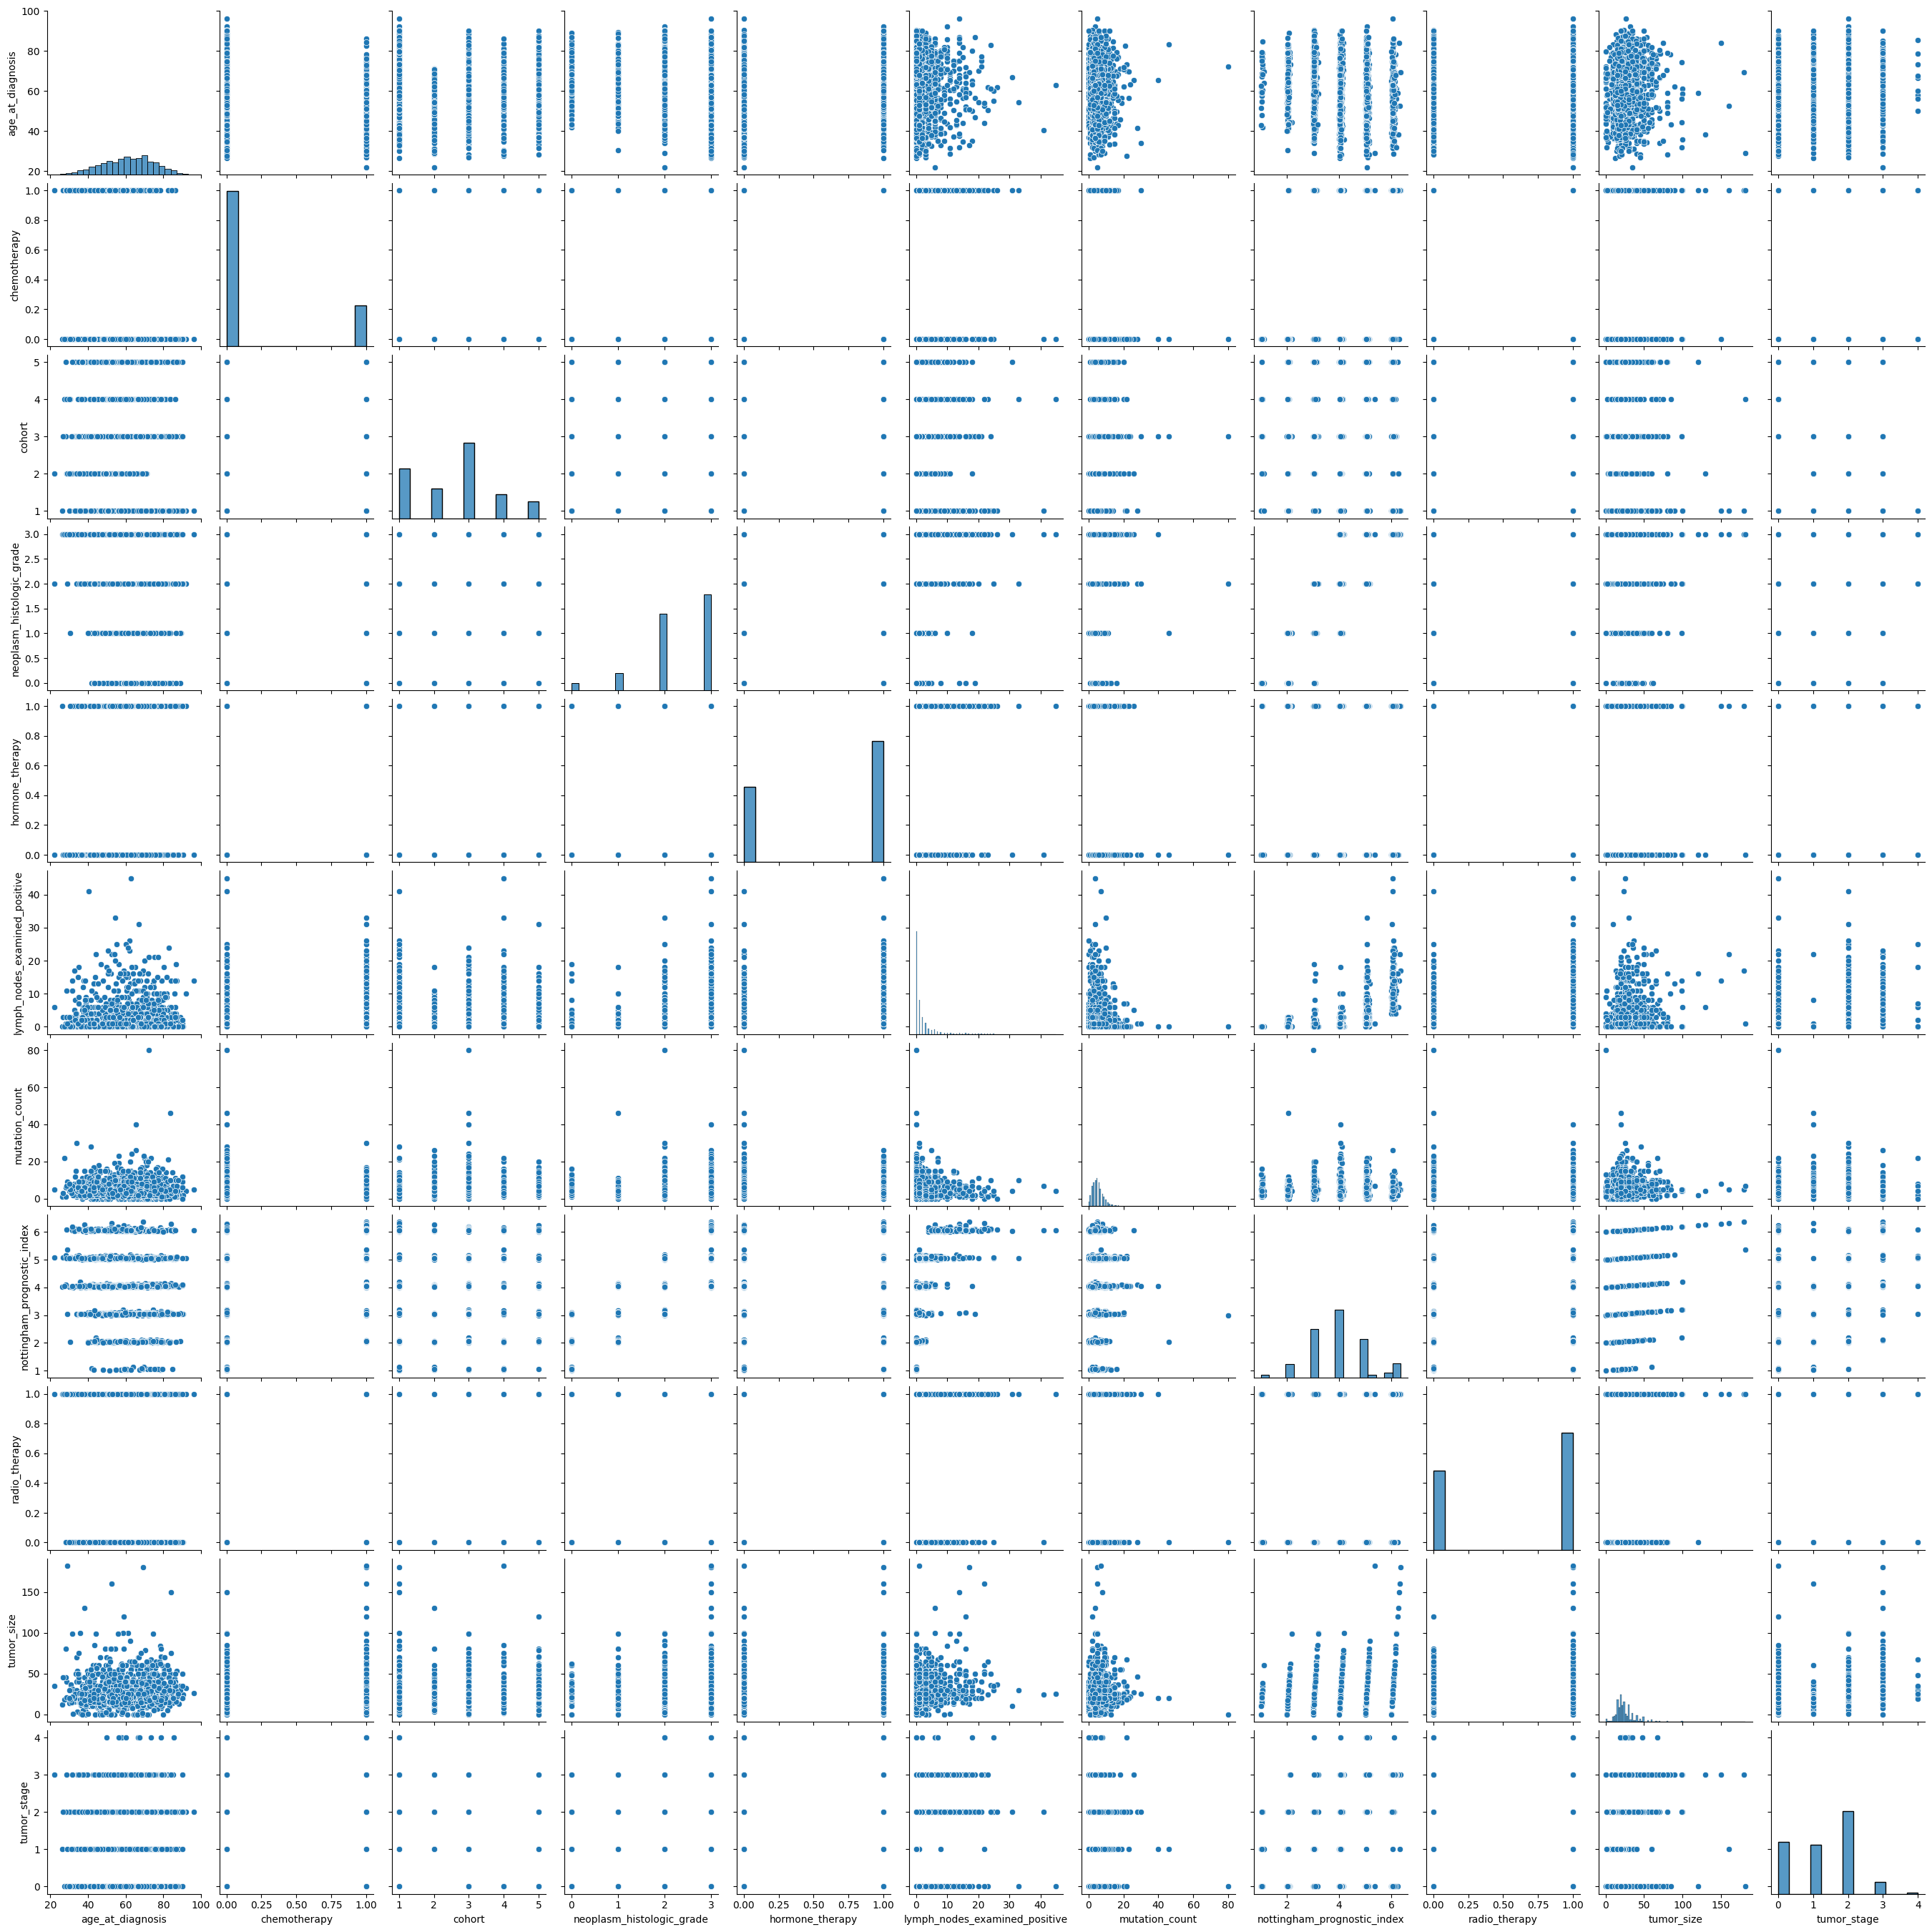

In [14]:
sns.pairplot(df_clin_wo_dataleak)

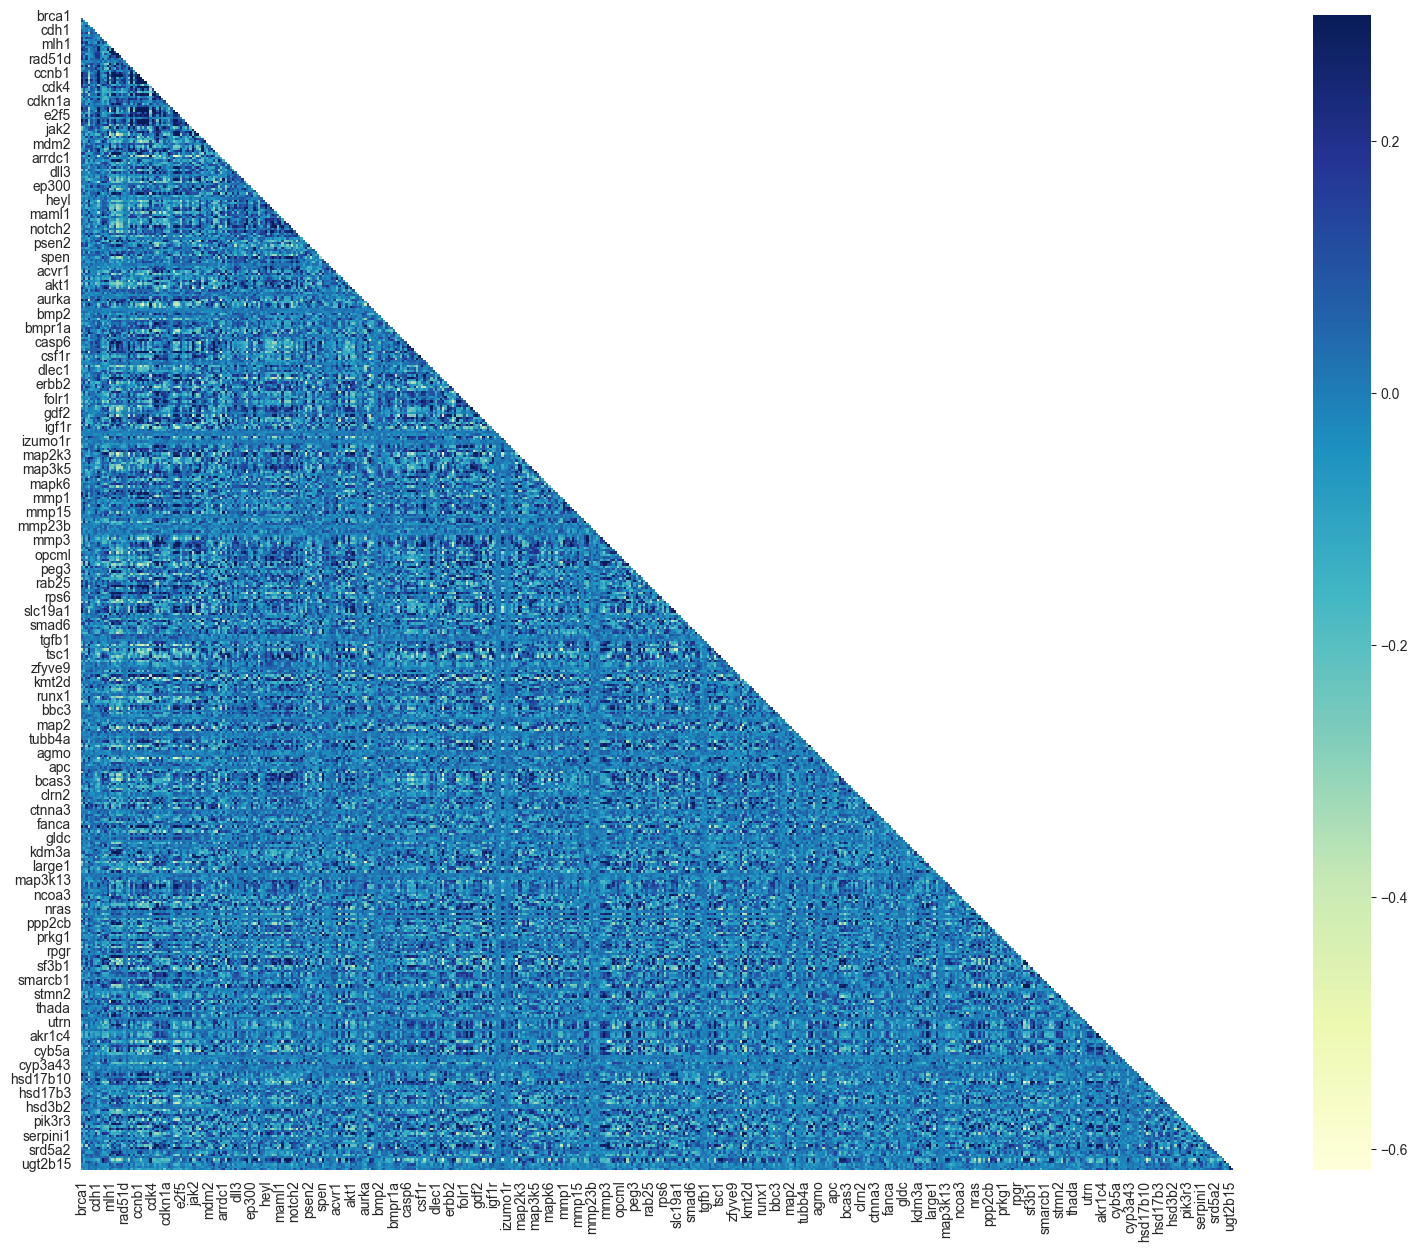

In [21]:
corr = df_expr.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()

In [60]:
df_expr.reindex(df_expr.mean().sort_values(ascending=False).index, axis=1).describe()

,nfkb2,rad51c,pdgfrb,jag1,psen2,hdac1,pik3r1,col12a1,wfdc2,fgfr1,...,mapk14,arid2,mdc1,star,raf1,kmt2d,gldc,nfkb1,cyp17a1,ahnak
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,...,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,...,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000002,-0.000003
std,1.000263,1.000263,1.000263,1.000263,1.000263,1.000263,1.000264,1.000263,1.000264,1.000262,...,1.000264,1.000264,1.000262,1.000262,1.000263,1.000263,1.000263,1.000265,1.000263,1.000262
min,-2.493500,-3.256700,-4.714100,-3.005800,-3.430500,-5.982100,-2.957400,-2.843000,-1.981600,-1.736700,...,-2.936700,-3.537900,-3.604500,-2.981700,-3.047500,-4.008100,-0.966700,-4.563500,-2.852100,-5.198200
25%,-0.660650,-0.616350,-0.622400,-0.648675,-0.696700,-0.624200,-0.707550,-0.724900,-0.684600,-0.570175,...,-0.731475,-0.668700,-0.653825,-0.632900,-0.641325,-0.691225,-0.554925,-0.645775,-0.666600,-0.544700
50%,-0.126900,-0.133350,0.067300,-0.026300,0.007200,0.002750,-0.023400,0.001200,-0.206550,-0.188050,...,-0.045100,-0.018600,-0.072950,-0.026650,-0.084200,-0.052800,-0.382400,0.039550,-0.053300,0.114400
75%,0.453700,0.493525,0.731125,0.615975,0.628700,0.613750,0.658975,0.747600,0.483975,0.297950,...,0.671800,0.627450,0.596600,0.590350,0.504125,0.618125,0.064175,0.655225,0.562425,0.630100
max,5.892300,4.405400,2.695100,7.050100,3.781400,4.196100,3.402700,2.608800,6.526300,10.447100,...,3.990100,3.878400,5.867000,12.742300,7.407100,4.636000,6.346700,3.821300,6.534500,3.329000


## Dimension Reduction (20 + Up to 10 Points Optional)

For each dataset, investigate whether it is needed to use a dimensionality reduction approach or not. If yes, please reduce the dataset's dimension. You can use UMAP for this purpose but any other approach is acceptable. Finding the most important features contains extra points.

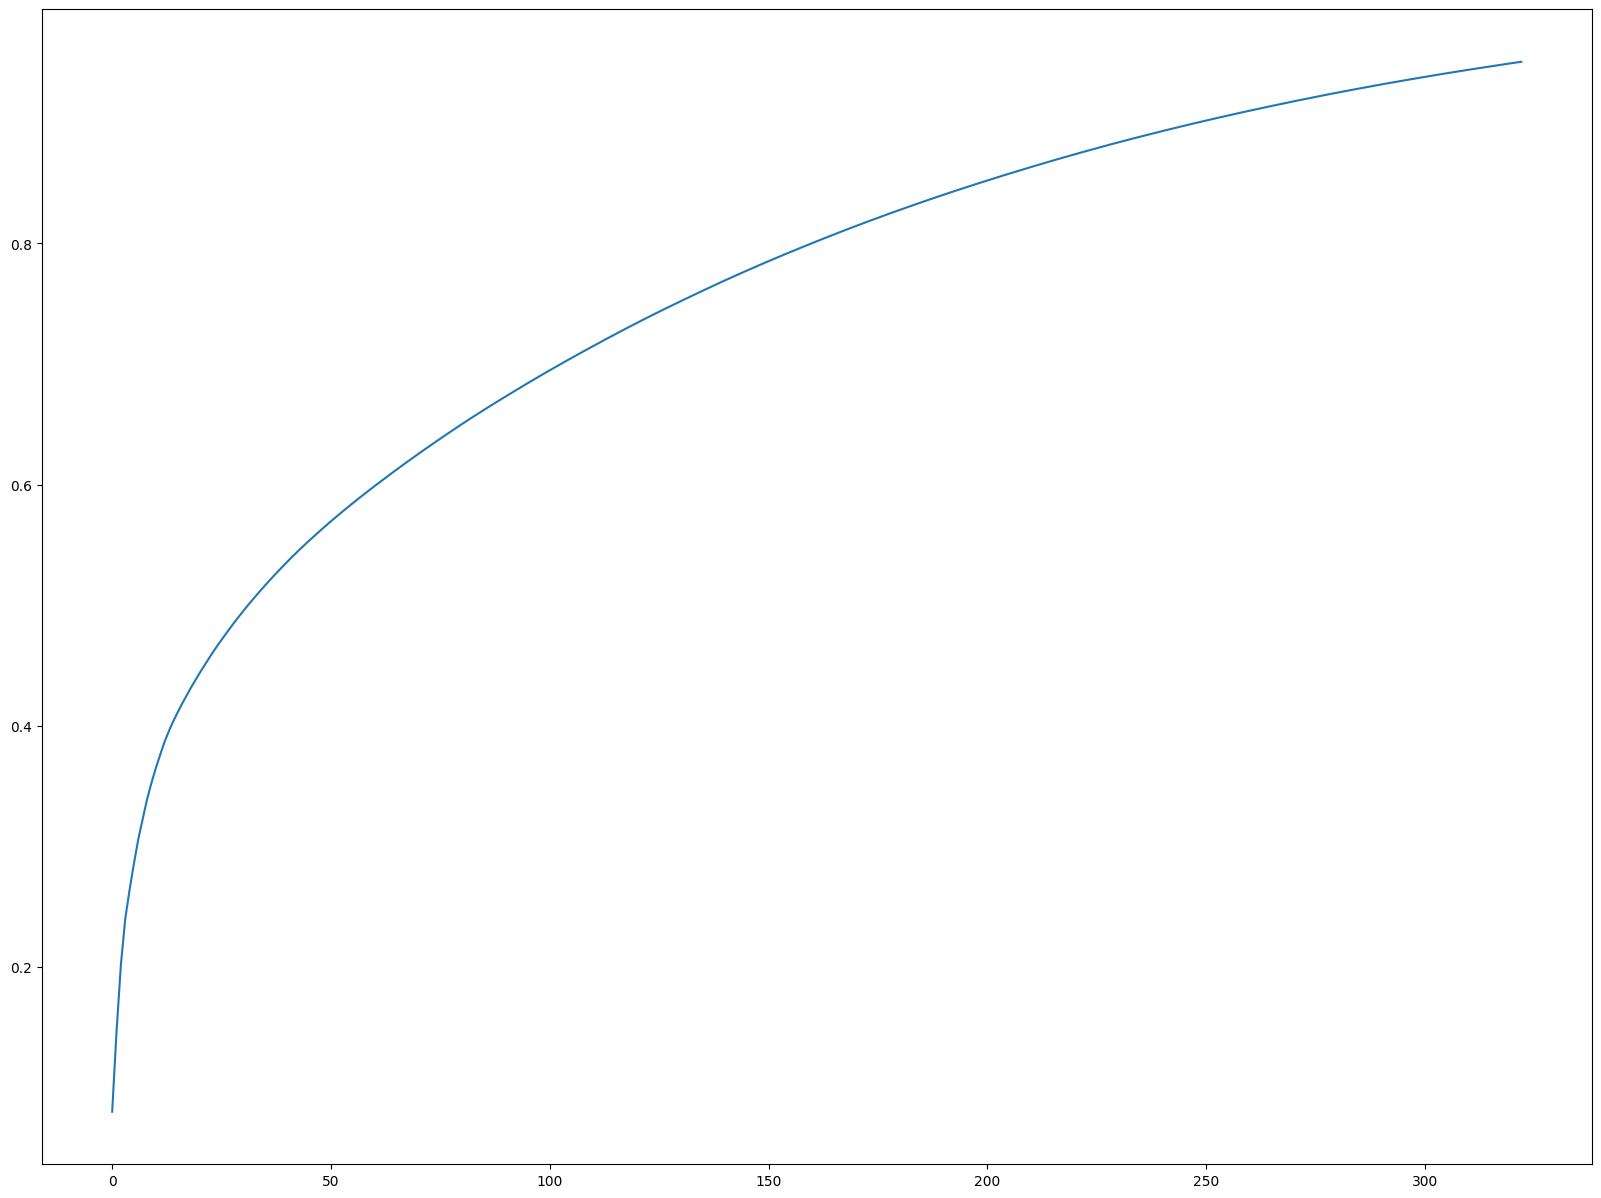

In [28]:
from sklearn.decomposition import PCA


pca = PCA(0.95)
pca.fit(np.array(arr_expr))
plt.plot(np.cumsum(pca.explained_variance_ratio_))


Doesn't seem logical. Takes 330 PC's just to reach 0.9 variance.

Loss: 11.13965 | LR: 0.00000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [07:06<00:00, 11.72it/s]


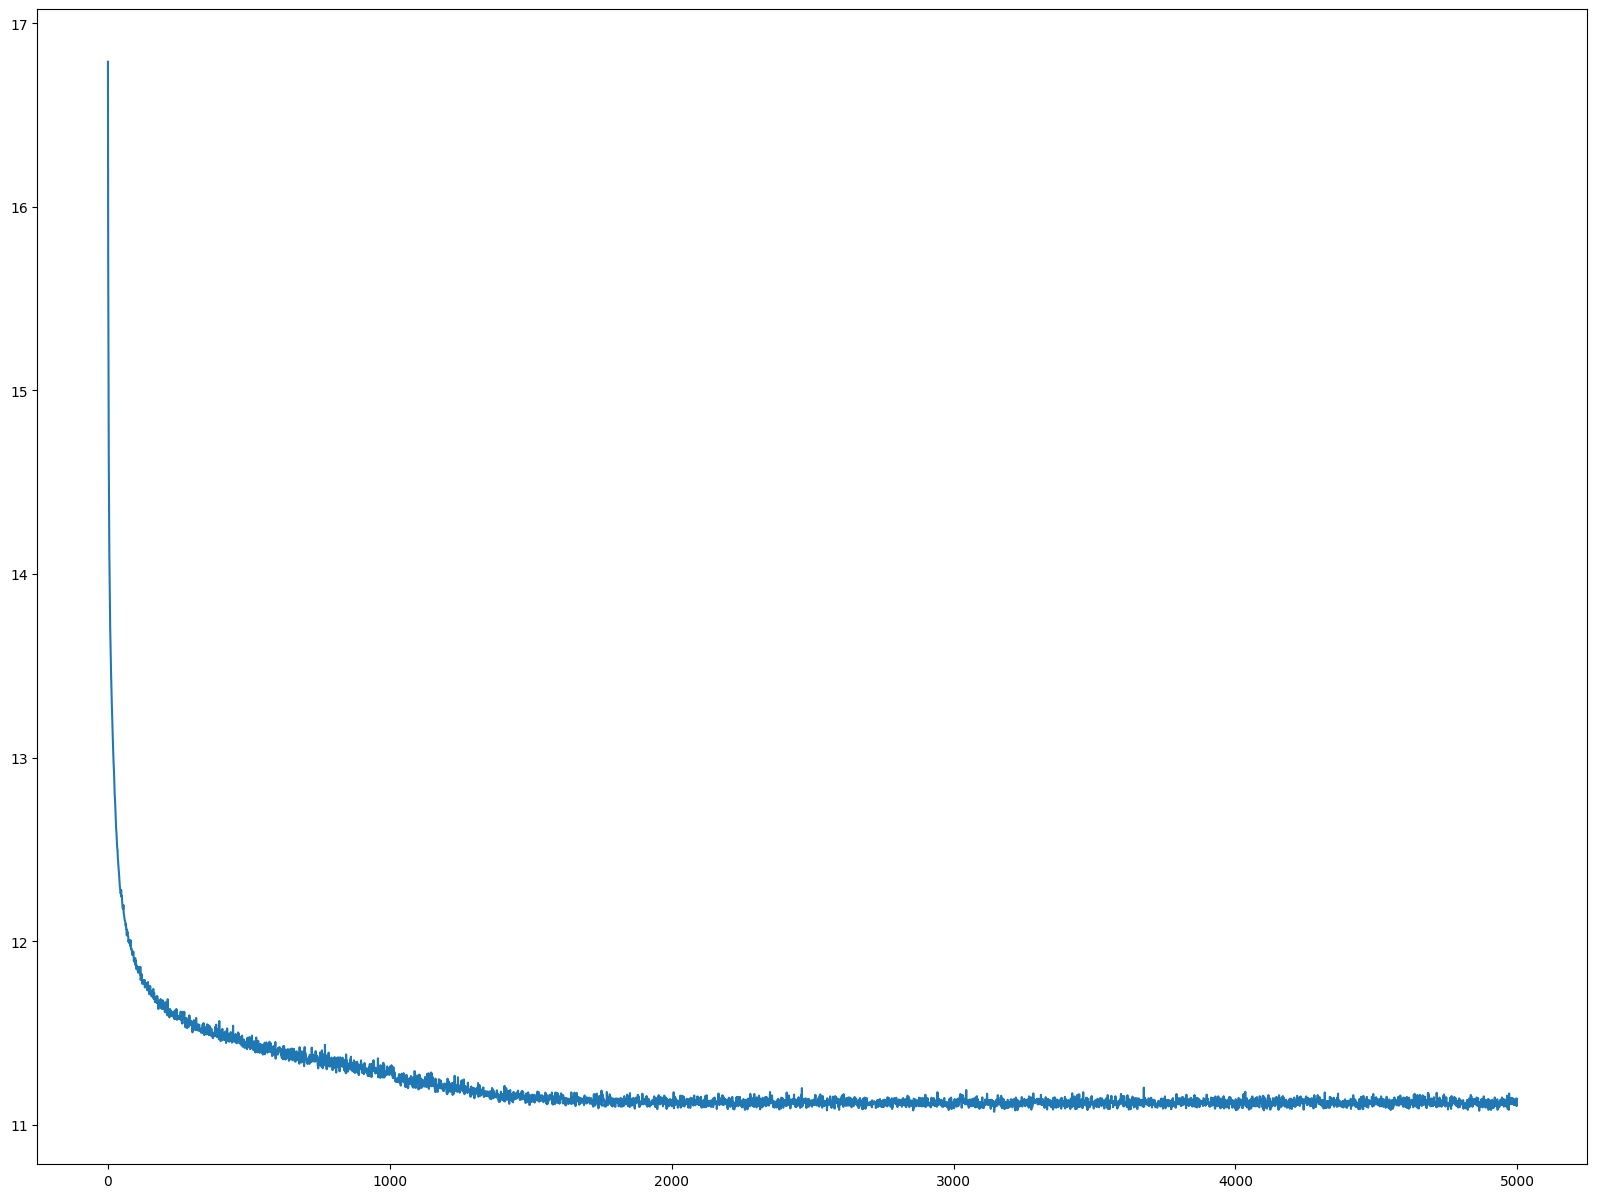

In [29]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'


class ds(torch.utils.data.Dataset):
    def __init__(self, data, label):
        assert len(data) == len(label)
        self.data = torch.tensor(np.array(data, dtype=np.float32))
        self.label = torch.tensor(label)

        for i in range(data.shape[1]):
            std = torch.std(self.data[:, i])
            if std == 0:
                self.data[:, i] = 0
            else:
                self.data[:, i] = (self.data[:, i] -
                                   torch.mean(self.data[:, i]))/std

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class AutoEncoder(nn.Module):
    def __init__(self, in_shape, enc_shape):
        super(AutoEncoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, enc_shape)
        )

        self.decode = nn.Sequential(
            nn.Linear(enc_shape, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, in_shape)
        )

    def forward(self, x):
        out = self.encode(x)
        out = self.decode(out)
        return out


output_shape = 2
train_loader = torch.utils.data.DataLoader(
    ds(arr_expr, label), batch_size=128, shuffle=True, drop_last=False)
model = AutoEncoder(arr_expr.shape[1], output_shape).to(dev)
criterion = nn.MSELoss().to(dev)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.7, patience=50)
epochs = 5000
trainloss_col = []

pbar = tqdm(range(epochs))
for epoch in pbar:
    loss = 0
    model.train()
    for x, y in train_loader:
        x = x.to(dev)
        y = y.to(dev)
        optimizer.zero_grad()
        out = model(x)
        criout = criterion(out, x)
        loss += float(criout)
        criout.backward()
        optimizer.step()
    scheduler.step(loss)
    trainloss_col.append(loss)
    pbar.set_description(
        f'Loss: {trainloss_col[epoch]:.5f} | LR: {optimizer.param_groups[0]["lr"]:.5f}')

plt.plot(trainloss_col)


### Important Gene Expression Features

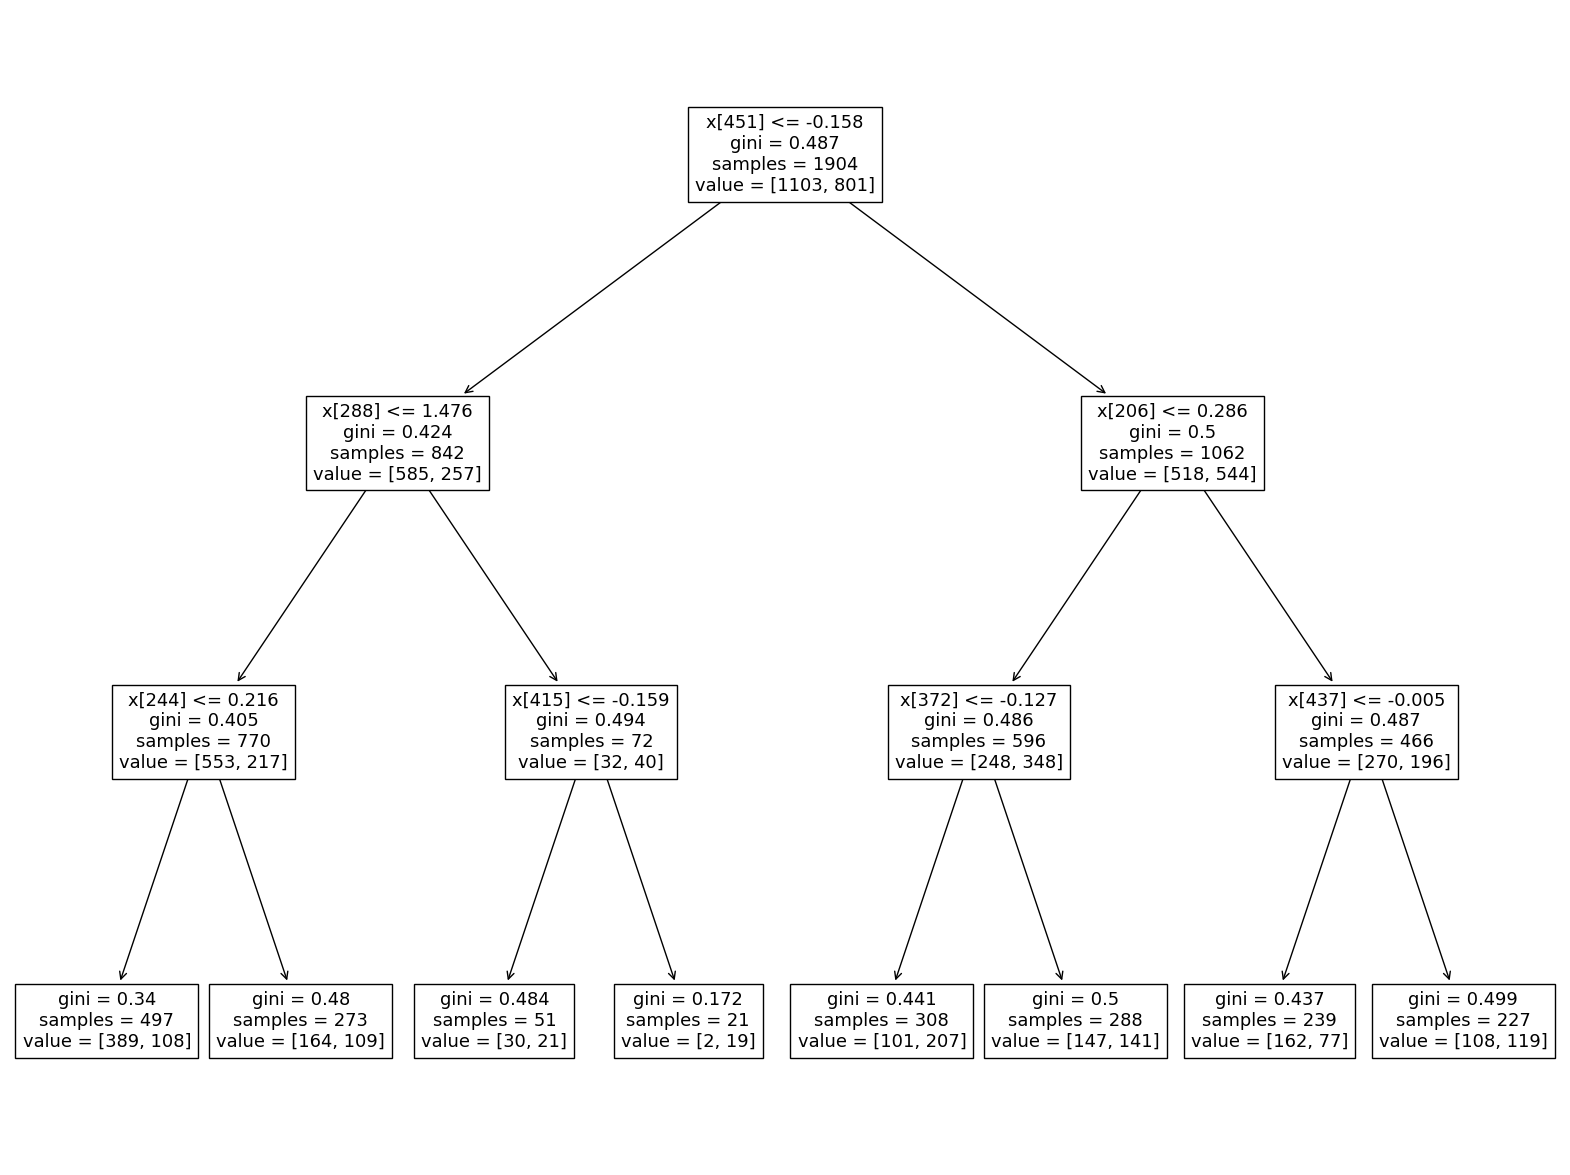

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(arr_expr, label)
plot_tree(dt)
plt.show()


In [31]:
np.array(cols_expr)[[451, 206, 288]]


array(['hsd17b11', 'mmp11', 'runx1'], dtype='<U9')

In [32]:
clf = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.5, objective='binary:logistic')
clf.fit(arr_expr,label)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

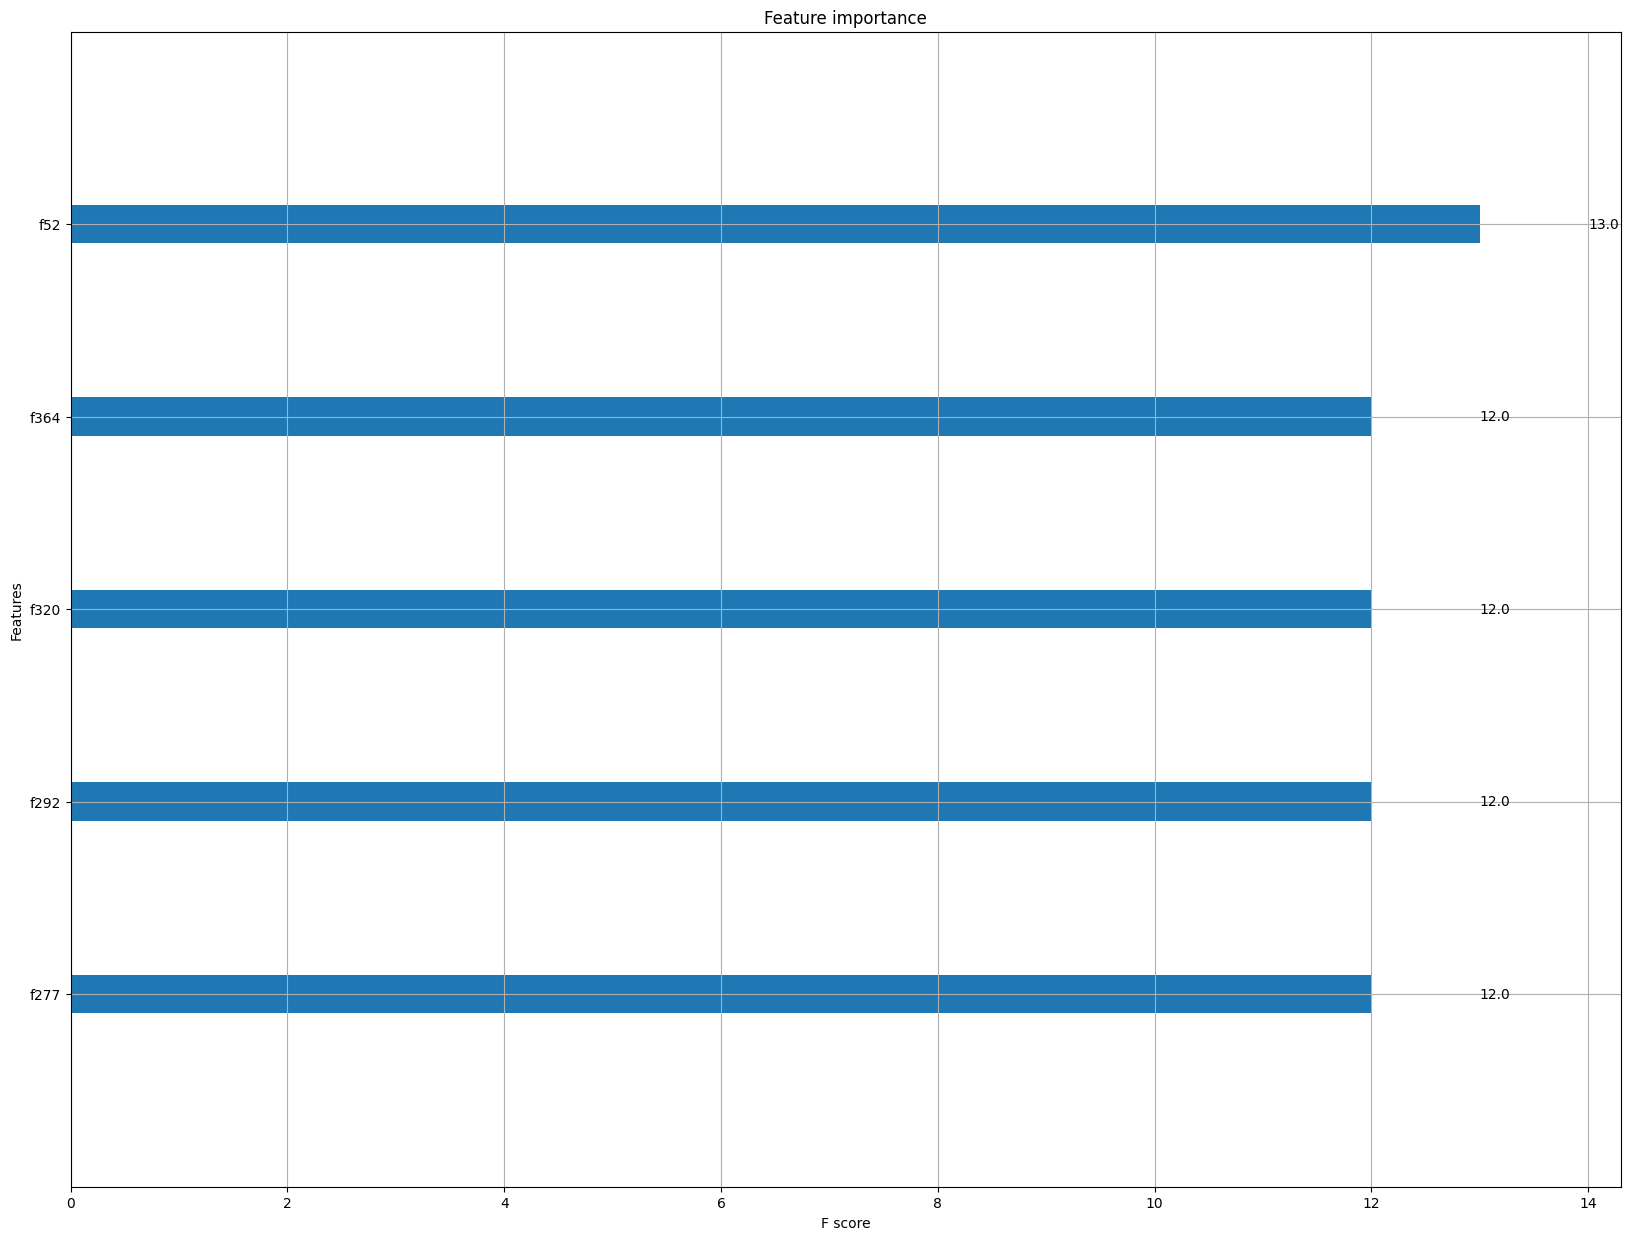

In [33]:
xgb.plot_importance(clf, max_num_features=5)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [34]:
np.array(cols_expr)[[52, 364, 320, 292, 277]]

array(['stat5a', 'magea8', 'arid5b', 'abcc1', 'arid1a'], dtype='<U9')

### 2 Feature AE vs PCA

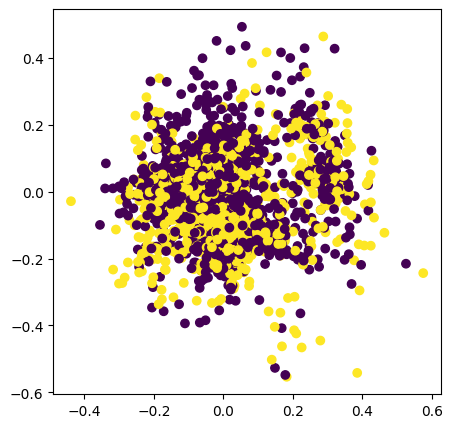

In [35]:
model.eval()
temp = model.encode(torch.tensor(np.array(arr_expr, dtype=np.float32)).to(dev))
temp = temp.cpu().detach().numpy()
plt.scatter(temp[:, 0], temp[:, 1], c=label)


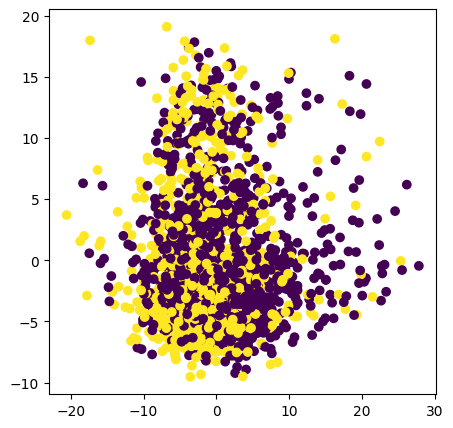

In [36]:
pca = PCA(2)
temp = pca.fit_transform(arr_expr)
plt.scatter(temp[:, 0], temp[:, 1], c=label)


### AutoEncoder

Loss: 5.56246 | LR: 0.00000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [07:12<00:00, 11.56it/s]


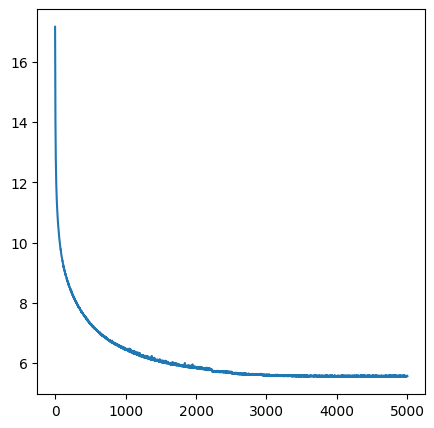

In [37]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'


class AutoEncoder(nn.Module):
    def __init__(self, in_shape, enc_shape):
        super(AutoEncoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, enc_shape)
        )

        self.decode = nn.Sequential(
            nn.Linear(enc_shape, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, in_shape)
        )

    def forward(self, x):
        out = self.encode(x)
        out = self.decode(out)
        return out


output_shape = 64
train_loader = torch.utils.data.DataLoader(
    ds(arr_expr, label), batch_size=128, shuffle=True, drop_last=False)
model = AutoEncoder(arr_expr.shape[1], output_shape).to(dev)
criterion = nn.MSELoss().to(dev)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.7, patience=50)
epochs = 5000
trainloss_col = []

pbar = tqdm(range(epochs))
for epoch in pbar:
    loss = 0
    model.train()
    for x, y in train_loader:

        x = x.to(dev)
        y = y.to(dev)

        optimizer.zero_grad()
        out = model(x)

        criout = criterion(out, x)
        loss += float(criout)

        criout.backward()
        optimizer.step()
    scheduler.step(loss)

    trainloss_col.append(loss)
    pbar.set_description(
        f'Loss: {trainloss_col[epoch]:.5f} | LR: {optimizer.param_groups[0]["lr"]:.5f}')

plt.plot(trainloss_col)


In [38]:
arr_expr_red = model.encode(torch.tensor(
    np.array(arr_expr, dtype=np.float32)).to(dev))
arr_expr_red = np.array(arr_expr_red.cpu().detach())
arr_expr_red.shape


(1904, 64)

# Classic Model (25 Points)

In this section, you must implement a classic classification model for clinical, gene expressions, and reduced gene expressions datasets. Using Random Forest is suggested. (minimum acceptable accuracy = 60%)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [40]:
x_train, x_test, y_train, y_test = train_test_split(
    arr_expr, label, test_size=0.33, random_state=8)
x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(
    arr_expr_red, label, test_size=0.33, random_state=10)
x_train_clin, x_test_clin, y_train_clin, y_test_clin = train_test_split(
    arr_clin, label, test_size=0.33, random_state=12)

### Gene Expression
#### Random Forest

In [41]:
# parameters = {'max_depth': [
#     i + 1 for i in range(10)], 'min_samples_split': [5, 10, 15, 20]}
rf = RandomForestClassifier(100, max_depth=8, min_samples_split=15)
# cv = GridSearchCV(rf, param_grid=parameters)
rf.fit(x_train, y_train)


RandomForestClassifier(max_depth=8, min_samples_split=15)

In [42]:
# rf = cv.best_estimator_
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)
print(f'TRAIN\tACC: {accuracy_score(y_train_pred, y_train):.3f} | F1: {f1_score(y_train_pred, y_train):.3f}')
print(f'TEST\tACC: {accuracy_score(y_test_pred, y_test):.3f} | F1: {f1_score(y_test_pred, y_test):.3f}')


TRAIN	ACC: 0.958 | F1: 0.946
TEST	ACC: 0.606 | F1: 0.380


#### XGBoost

In [43]:
clf = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.5, objective='binary:logistic')
clf.fit(x_train,y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
print(f'TRAIN\tACC: {accuracy_score(y_train_pred, y_train):.3f} | F1: {f1_score(y_train_pred, y_train):.3f}')
print(f'TEST\tACC: {accuracy_score(y_test_pred, y_test):.3f} | F1: {f1_score(y_test_pred, y_test):.3f}')

TRAIN	ACC: 1.000 | F1: 1.000
TEST	ACC: 0.609 | F1: 0.496


### Gene Expression Reduced
#### Random Forest

In [44]:
# parameters = {'max_depth': [2*i + 1 for i in range(10)], 'min_samples_split': [
#     5, 10, 15], 'n_estimators': [50, 75, 100]}
rf = RandomForestClassifier(
    n_estimators=100, max_depth=8, min_samples_split=15)
# cv = GridSearchCV(rf, param_grid=parameters)
rf.fit(x_train_red, y_train_red)


RandomForestClassifier(max_depth=8, min_samples_split=15)

In [45]:
# rf = cv.best_estimator_
y_train_pred = rf.predict(x_train_red)
y_test_pred = rf.predict(x_test_red)
print(f'TRAIN\tACC: {accuracy_score(y_train_pred, y_train_red):.3f} | F1: {f1_score(y_train_pred, y_train_red):.3f}')
print(f'TEST\tACC: {accuracy_score(y_test_pred, y_test_red):.3f} | F1: {f1_score(y_test_pred, y_test_red):.3f}')


TRAIN	ACC: 0.947 | F1: 0.932
TEST	ACC: 0.612 | F1: 0.393


#### XGBoost

In [46]:
clf = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.5, objective='binary:logistic')
clf.fit(x_train_red,y_train_red)
y_train_pred = clf.predict(x_train_red)
y_test_pred = clf.predict(x_test_red)
print(f'TRAIN\tACC: {accuracy_score(y_train_pred, y_train_red):.3f} | F1: {f1_score(y_train_pred, y_train_red):.3f}')
print(f'TEST\tACC: {accuracy_score(y_test_pred, y_test_red):.3f} | F1: {f1_score(y_test_pred, y_test_red):.3f}')

TRAIN	ACC: 1.000 | F1: 1.000
TEST	ACC: 0.603 | F1: 0.488


### Clinical

#### Random Forest

In [47]:
# parameters = {'max_depth':[2*i + 1 for i in range(10)], 'min_samples_split':[5, 10, 15], 'n_estimators':[50, 75, 100]}
rf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=15)
# cv = GridSearchCV(rf, param_grid=parameters)
rf.fit(x_train_clin, y_train_clin)

RandomForestClassifier(max_depth=8, min_samples_split=15)

In [48]:
# rf = cv.best_estimator_

y_train_pred = rf.predict(x_train_clin)
y_test_pred = rf.predict(x_test_clin)
print(f'TRAIN\tACC: {accuracy_score(y_train_pred, y_train_clin):.3f} | F1: {f1_score(y_train_pred, y_train_clin):.3f}')
print(f'TEST\tACC: {accuracy_score(y_test_pred, y_test_clin):.3f} | F1: {f1_score(y_test_pred, y_test_clin):.3f}')


TRAIN	ACC: 0.839 | F1: 0.796
TEST	ACC: 0.706 | F1: 0.611


#### XGBoost

In [49]:
clf = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.5, objective='binary:logistic')
clf.fit(x_train_clin,y_train_clin)
y_train_pred = clf.predict(x_train_clin)
y_test_pred = clf.predict(x_test_clin)
print(f'TRAIN\tACC: {accuracy_score(y_train_pred, y_train_clin):.3f} | F1: {f1_score(y_train_pred, y_train_clin):.3f}')
print(f'TEST\tACC: {accuracy_score(y_test_pred, y_test_clin):.3f} | F1: {f1_score(y_test_pred, y_test_clin):.3f}')

TRAIN	ACC: 1.000 | F1: 1.000
TEST	ACC: 0.669 | F1: 0.595


### Important Clinical Features

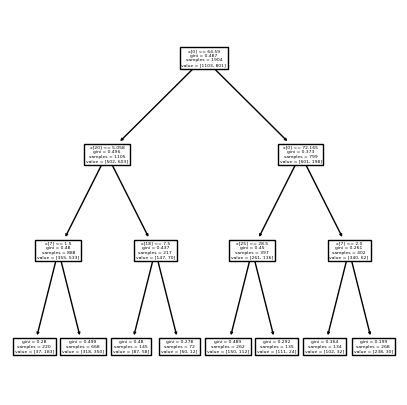

In [50]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(arr_clin, label)
plot_tree(dt)
plt.show()

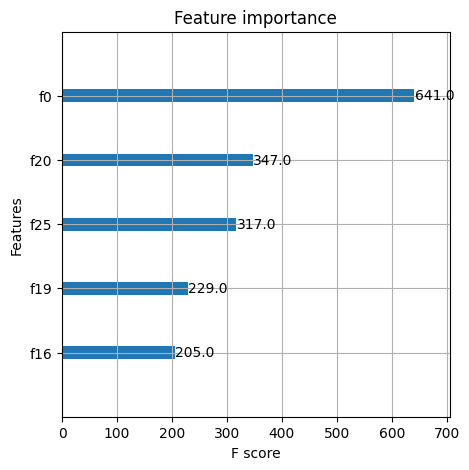

In [51]:
xgb.plot_importance(clf, max_num_features=5)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [52]:
np.array(df_clin_wo_dataleak.columns)[[0, 20, 25, 19, 16]]

array(['age_at_diagnosis', 'nottingham_prognostic_index', 'tumor_size',
       'mutation_count', 'integrative_cluster'], dtype=object)

# Neural Network (30 Points)

In this section, you must implement a neural network model for clinical, gene expressions and reduced gene expressions datasets. Using the MPL models is suggested. (minimum acceptable accuracy = 60%)

In [53]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'


class MLP(nn.Module):
    def __init__(self, in_shape, out_shape):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_shape, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64, out_shape),
        )

    def forward(self, x):
        out = self.mlp(x)
        return out


Loss: 0.13595 | LR: 0.01668 | Acc: 1.000 | F1: 1.000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:09<00:00, 21.56it/s]


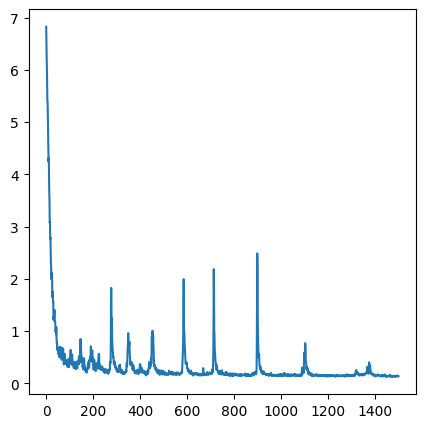

In [54]:
x_train, x_test, y_train, y_test = train_test_split(
    arr_expr, label, test_size=0.33, random_state=8)
train_loader = torch.utils.data.DataLoader(
    ds(x_train, y_train), batch_size=128, shuffle=True, drop_last=False)
test_loader = torch.utils.data.DataLoader(
    ds(x_test, y_test), batch_size=128, shuffle=False, drop_last=False)
model = MLP(arr_expr.shape[1], 2).to(dev)
criterion = nn.CrossEntropyLoss().to(dev)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=50)
epochs = 1500
trainloss_col = []

pbar = tqdm(range(epochs))
for epoch in pbar:
    loss = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    model.train()
    for x, y in train_loader:
        x = x.to(dev)
        y = y.to(dev)
        optimizer.zero_grad()
        out = model(x)
        criout = criterion(out, y)
        loss += float(criout)
        pred = torch.argmax(out, dim=1)
        TP += torch.sum((pred == y) & (pred == 1))
        TN += torch.sum((pred == y) & (pred == 0))
        FP += torch.sum((pred != y) & (pred == 1))
        FN += torch.sum((pred != y) & (pred == 0))
        criout.backward()
        optimizer.step()
    scheduler.step(loss)

    trainloss_col.append(loss)
    pbar.set_description(
        f'Loss: {trainloss_col[epoch]:.5f} | LR: {optimizer.param_groups[0]["lr"]:.5f} | Acc: {(TP+TN)/(TP+TN+FP+FN):.3f} | F1: {(TP+TP)/(TP+TP+FP+FN):.3f}')

plt.plot(trainloss_col)


In [55]:
model.eval()
TP = 0
TN = 0
FP = 0
FN = 0
for x, y in test_loader:
    x = x.to(dev)
    y = y.to(dev)
    optimizer.zero_grad()
    out = model(x)
    criout = criterion(out, y)
    pred = torch.argmax(out, dim=1)
    TP += torch.sum((pred == y) & (pred == 1))
    TN += torch.sum((pred == y) & (pred == 0))
    FP += torch.sum((pred != y) & (pred == 1))
    FN += torch.sum((pred != y) & (pred == 0))
print(f'Acc: {(TP+TN)/(TP+TN+FP+FN):.3f} | F1: {(TP+TP)/(TP+TP+FP+FN):.3f}')


Acc: 0.622 | F1: 0.551


Loss: 0.06101 | LR: 0.02542 | Acc: 0.999 | F1: 0.999: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:53<00:00, 27.78it/s]


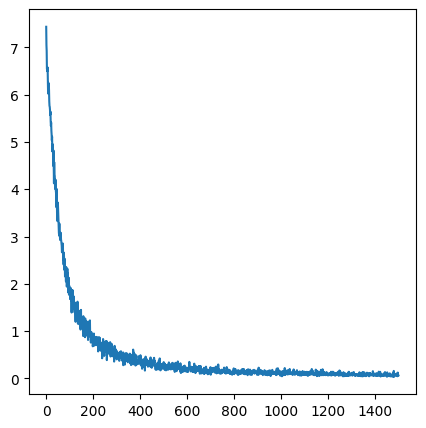

In [68]:
class MLP(nn.Module):
    def __init__(self, in_shape, out_shape):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_shape, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, out_shape)
        )

    def forward(self, x):
        out = self.mlp(x)
        return out

x_train, x_test, y_train, y_test = train_test_split(
    arr_expr_red, label, test_size=0.33, random_state=8)
train_loader = torch.utils.data.DataLoader(
    ds(x_train, y_train), batch_size=128, shuffle=True, drop_last=False)
test_loader = torch.utils.data.DataLoader(
    ds(x_test, y_test), batch_size=128, shuffle=False, drop_last=False)
model = MLP(x_train.shape[1], 2).to(dev)
criterion = nn.CrossEntropyLoss().to(dev)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=50)
epochs = 1500
trainloss_col = []

pbar = tqdm(range(epochs))
for epoch in pbar:
    loss = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    model.train()
    for x, y in train_loader:
        x = x.to(dev)
        y = y.to(dev)
        optimizer.zero_grad()
        out = model(x)
        criout = criterion(out, y)
        loss += float(criout)
        pred = torch.argmax(out, dim=1)
        TP += torch.sum((pred == y) & (pred == 1))
        TN += torch.sum((pred == y) & (pred == 0))
        FP += torch.sum((pred != y) & (pred == 1))
        FN += torch.sum((pred != y) & (pred == 0))
        criout.backward()
        optimizer.step()
    scheduler.step(loss)
    trainloss_col.append(loss)
    pbar.set_description(
        f'Loss: {trainloss_col[epoch]:.5f} | LR: {optimizer.param_groups[0]["lr"]:.5f} | Acc: {(TP+TN)/(TP+TN+FP+FN):.3f} | F1: {(TP+TP)/(TP+TP+FP+FN):.3f}')

plt.plot(trainloss_col)


In [69]:
model.eval()
TP = 0
TN = 0
FP = 0
FN = 0
for x, y in test_loader:
    x = x.to(dev)
    y = y.to(dev)
    optimizer.zero_grad()
    out = model(x)
    criout = criterion(out, y)
    pred = torch.argmax(out, dim=1)
    TP += torch.sum((pred == y) & (pred == 1))
    TN += torch.sum((pred == y) & (pred == 0))
    FP += torch.sum((pred != y) & (pred == 1))
    FN += torch.sum((pred != y) & (pred == 0))
print(f'Acc: {(TP+TN)/(TP+TN+FP+FN):.3f} | F1: {(TP+TP)/(TP+TP+FP+FN):.3f}')


Acc: 0.615 | F1: 0.527


Loss: 1.50342 | LR: 0.04783 | Acc: 0.951 | F1: 0.938: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:04<00:00, 23.35it/s]


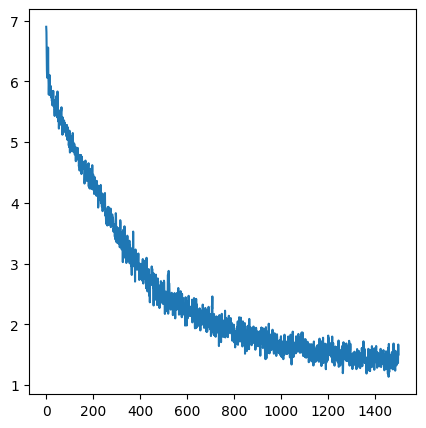

In [58]:
class MLP(nn.Module):
    def __init__(self, in_shape, out_shape):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_shape, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, out_shape)
        )

    def forward(self, x):
        out = self.mlp(x)
        return out


x_train, x_test, y_train, y_test = train_test_split(
    arr_clin, label, test_size=0.33, random_state=8)
train_loader = torch.utils.data.DataLoader(
    ds(x_train, y_train), batch_size=128, shuffle=True, drop_last=False)
test_loader = torch.utils.data.DataLoader(
    ds(x_test, y_test), batch_size=128, shuffle=False, drop_last=False)
model = MLP(x_train.shape[1], 2).to(dev)
criterion = nn.CrossEntropyLoss().to(dev)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=50)
epochs = 1500
trainloss_col = []

pbar = tqdm(range(epochs))
for epoch in pbar:
    loss = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    model.train()
    for x, y in train_loader:
        x = x.to(dev)
        y = y.to(dev)
        optimizer.zero_grad()
        out = model(x)
        criout = criterion(out, y)
        loss += float(criout)
        pred = torch.argmax(out, dim=1)
        TP += torch.sum((pred == y) & (pred == 1))
        TN += torch.sum((pred == y) & (pred == 0))
        FP += torch.sum((pred != y) & (pred == 1))
        FN += torch.sum((pred != y) & (pred == 0))
        criout.backward()
        optimizer.step()
    scheduler.step(loss)

    trainloss_col.append(loss)
    pbar.set_description(
        f'Loss: {trainloss_col[epoch]:.5f} | LR: {optimizer.param_groups[0]["lr"]:.5f} | Acc: {(TP+TN)/(TP+TN+FP+FN):.3f} | F1: {(TP+TP)/(TP+TP+FP+FN):.3f}')

plt.plot(trainloss_col)


In [59]:
model.eval()
TP = 0
TN = 0
FP = 0
FN = 0
for x, y in test_loader:
    x = x.to(dev)
    y = y.to(dev)
    optimizer.zero_grad()
    out = model(x)
    criout = criterion(out, y)
    pred = torch.argmax(out, dim=1)
    TP += torch.sum((pred == y) & (pred == 1))
    TN += torch.sum((pred == y) & (pred == 0))
    FP += torch.sum((pred != y) & (pred == 1))
    FN += torch.sum((pred != y) & (pred == 0))
print(f'Acc: {(TP+TN)/(TP+TN+FP+FN):.3f} | F1: {(TP+TP)/(TP+TP+FP+FN):.3f}')


Acc: 0.660 | F1: 0.593


# Model Comparison (10 Points)

Compare different models and different datasets (clinical, gene expressions, and gene reduced expressions) and try to explain their differences.

#### Clinical
Clinical data were very corelated with overal survival and both MLP and boosting methods were very efficient.
XGBoost showed better performance with the overall accuracy but MLP results had better F1 scores.
#### Gene Expression
Gene expression data had much better results with MLP than with boosting methods. This could be because of big feature count and small data size in comparison. boosting methods tend to overfit on simpler features and smaller feature count.
#### Gene Expression Reduced
With dimensionality reduction applied with an AutoEncoder, boosting methods started to act better than MLP. since a good amount of feature variance is lost in dimensionality reduction, results were worse than with original gene expression dataset.
#### Overall
Boosting methods work really well with tabular data and can perform better than MLP with very little fine tuning.
MLP tends to overperform boosting methods when there are a lot of features and we have a big dataset with lots of samples.
With less samples, It's more ideal to perform a dimensionality reduction with a classical method (PCA, TSNE and UMAP) or an AutoEncoder and use boosting methods to perform the final classification.